In [6]:
# load libraries
import netCDF4 as nc
import xarray as xr
import glob
import pandas as pd
import os
from itertools import zip_longest
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cf
import ruptures as rpt
from datetime import datetime
import pymannkendall as mk

# Change Point Detection

- Binary segmentation
- Bottom up segmentation
- Pruned Exact Linear Time (PELT)
- Mann-Kendall

The first dataset to train these models on will be the Closeness Centrality (CC) dataset of 2003.

## Data preparation

In [3]:
# CC data 2003
file_pattern = '../../private/complex_network_coefficients/2000-2009_run_20240105_1808/rasterfiles/Europe/2003/CN_Europe_0.25x0.25deg_CC_2003-*.nc'
file_paths = glob.glob(file_pattern)

# Open and concatenate files
cc_2003 = xr.open_mfdataset(file_paths)

# Rename coefficient
cc_2003 = cc_2003.rename({'coefficient': 'CC'})

# Save the merged data to a new NetCDF file
if os.path.exists("cc_2003.nc"):
    os.remove("cc_2003.nc")
    cc_2003.to_netcdf("cc_2003.nc")
else:
    cc_2003.to_netcdf("cc_2003.nc")

In [409]:
# DC data 2003
file_pattern = '../../private/complex_network_coefficients/2000-2009_run_20240105_1808/rasterfiles/Europe/2003/CN_Europe_0.25x0.25deg_DC_2003-*.nc'
file_paths = glob.glob(file_pattern)

# Open and concatenate files
dc_2003 = xr.open_mfdataset(file_paths)

# Rename coefficient
dc_2003 = dc_2003.rename({'coefficient': 'DC'})

# Save the merged data to a new NetCDF file
if os.path.exists("dc_2003.nc"):
    os.remove("dc_2003.nc")
    dc_2003.to_netcdf("dc_2003.nc")
else:
    dc_2003.to_netcdf("dc_2003.nc")

In [29]:
# is_heatwave data 2003
file_pattern = '../../private/is_heatwave/Europe_0.25deg/Europe_0.25deg_2003-*.nc'
file_paths = glob.glob(file_pattern)

# Open and concatenate files
ih_2003 = xr.open_mfdataset(file_paths)

# Save the merged data to a new NetCDF file
if os.path.exists("ih_2003.nc"):
    os.remove("ih_2003.nc")
    ih_2003.to_netcdf("ih_2003.nc")
else:
    ih_2003.to_netcdf("ih_2003.nc")

## Data exploration

In [26]:
def merge_to_df(year):
    file_pattern = '../../private/is_heatwave/Europe_0.25deg/Europe_0.25deg_' + year + '-*.nc'
    file_paths = glob.glob(file_pattern)

    # Merge all files into a single dataset
    globals()["ds_"+year] = xr.merge([xr.open_dataset(f) for f in file_paths])

    globals()["df_"+year] = globals()["ds_"+year].to_dataframe().reset_index()
    
    return globals()["df_"+year]

def convert_to_days(year):
    basedate = pd.to_datetime(year + "-01-01")
    globals()["df_"+year] = merge_to_df(year)
    
    for i in range(len(globals()["df_"+year].time)):
        globals()["df_"+year].time[i] = (globals()["df_"+year].time[i] - basedate).days + 1
    return globals()["df_"+year]

def density(year):
    year = str(year)
    globals()["df_"+year] = convert_to_days(year)
    
    days = []
    coordinates = []
    for i in range(len(globals()["df_"+year].time)):
        if globals()["df_"+year].is_heatwave[i] != 0.0:
            coord = (globals()["df_"+year].x[i], globals()["df_"+year].y[i])
            if not coord in coordinates:
                coordinates.append((globals()["df_"+year].x[i], globals()["df_"+year].y[i]))
                days.append(globals()["df_"+year].time[i])
    return days

def create_df(range_min, range_max):
    data = []
    col = []
    
    for i in range(range_min, range_max):
        density_data = density(i)
        data.append(density_data)

    data_t = list(zip_longest(*data))
    
    for j in range(range_min, range_max):
        col.append(str(j))
        
    df = pd.DataFrame(data_t, columns=col)
    return df

In [27]:
%%capture
df_2003 = create_df(2003, 2004)

# Save the merged data to a new NetCDF file
if os.path.exists("df_2003.csv"):
    os.remove("df_2003.csv")
    df_2003.to_csv("df_2003.csv", index=False)
else:
    df_2003.to_csv("df_2003.csv", index=False)

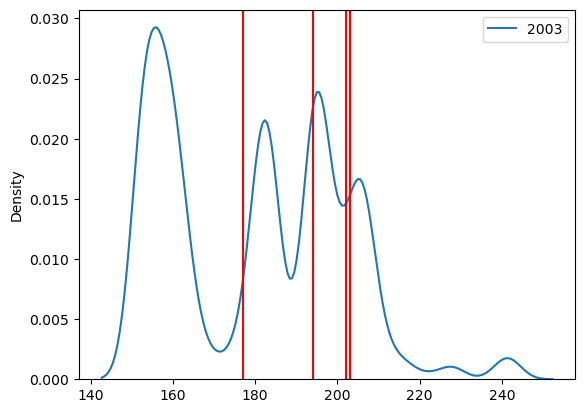

In [392]:
#create density plot of data
sns.kdeplot(df_2003)
plt.axvline(177, color='red')
plt.axvline(194, color='red')
plt.axvline(202, color='red')
plt.axvline(203, color='red')

### Is heatwave

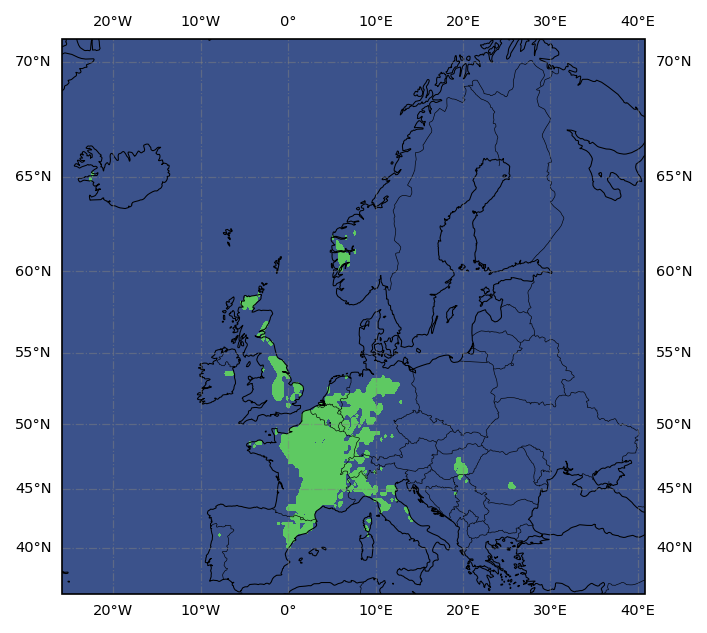

In [11]:
# First we specify Coordinate Refference System for Map Projection
# We will use Mercator, which is a cylindrical, conformal projection. 
# It has bery large distortion at high latitudes, cannot 
# fully reach the polar regions.
projection = ccrs.Mercator()

# Specify CRS, that will be used to tell the code, where should our data be plotted
crs = ccrs.PlateCarree()

# Now we will create axes object having specific projection 
plt.figure(dpi=150)
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}

# To plot borders and coastlines, we can use cartopy feature
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

dataset = nc.Dataset("ih_2003.nc")

sst = dataset.variables['is_heatwave'][0, :, :]
lats = dataset.variables['x'][:]
lons = dataset.variables['y'][:]

plt.contourf(lons, lats, sst, 1,
             transform=ccrs.PlateCarree())

plt.show()

### CC

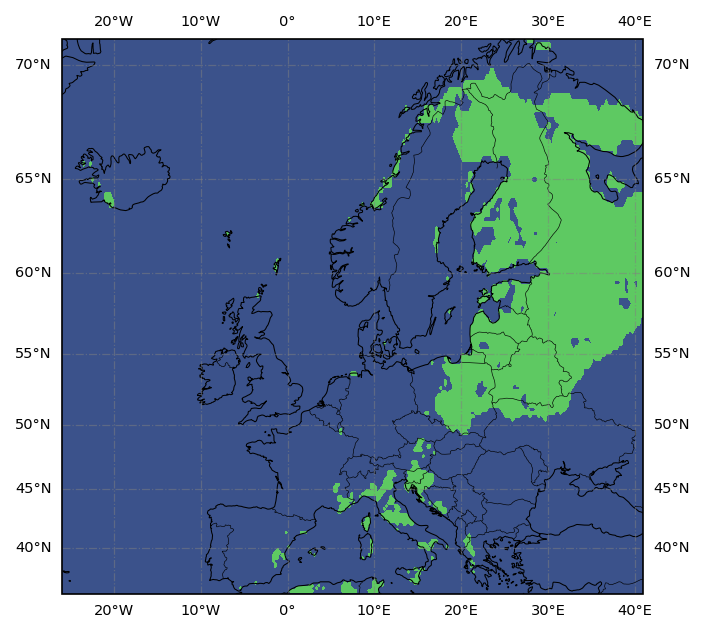

In [20]:
# First we specify Coordinate Refference System for Map Projection
# We will use Mercator, which is a cylindrical, conformal projection. 
# It has bery large distortion at high latitudes, cannot 
# fully reach the polar regions.
projection = ccrs.Mercator()

# Specify CRS, that will be used to tell the code, where should our data be plotted
crs = ccrs.PlateCarree()

# Now we will create axes object having specific projection 
plt.figure(dpi=150)
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}

# To plot borders and coastlines, we can use cartopy feature
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

dataset = nc.Dataset("cc_2003.nc")

sst = dataset.variables['CC'][56, :, :] #52
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

plt.contourf(lons, lats, sst, 1,
             transform=ccrs.PlateCarree())

plt.show()

### DC

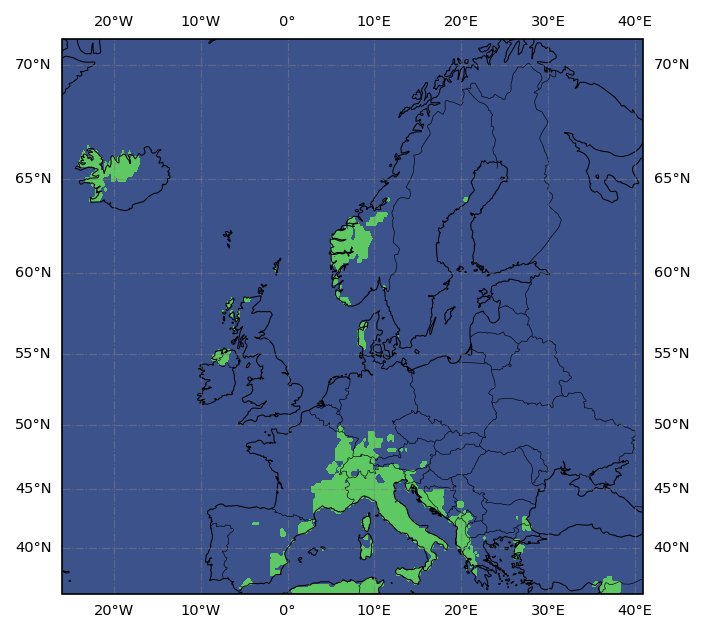

In [422]:
# First we specify Coordinate Refference System for Map Projection
# We will use Mercator, which is a cylindrical, conformal projection. 
# It has bery large distortion at high latitudes, cannot 
# fully reach the polar regions.
projection = ccrs.Mercator()

# Specify CRS, that will be used to tell the code, where should our data be plotted
crs = ccrs.PlateCarree()

# Now we will create axes object having specific projection 
plt.figure(dpi=150)
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}

# To plot borders and coastlines, we can use cartopy feature
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

dataset = nc.Dataset("dc_2003.nc")

sst = dataset.variables['DC'][26, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

plt.contourf(lons, lats, sst, 1,
             transform=ccrs.PlateCarree())

plt.show()

## Binary segmentation

In [6]:
# Load your NetCDF file and variable
data = nc.Dataset('cc_2003.nc')
variable = data['CC']
ds = xr.open_dataset('cc_2003.nc')

arr_1D = flatten(np.array(variable))

In [14]:
# model = "l2"  
# algo = rpt.Binseg(model=model).fit(arr_1D)
# my_bkps = algo.predict(n_bkps=10)

## Bottom up segmentation

In [2]:
# Flatten 3D array of Closeness Centrality into 1D array
def flatten(data):
    flat_data = []
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            for k in range(data.shape[0]):
                flat_data.append(data[k][j][i])
    return np.array(flat_data)

# Make predictions with Bottom Up Segmentation algorithm on sources and sinks
def bottomup(arr_1D, m, j):
    algo = rpt.BottomUp(model=m, jump=j).fit(arr_1D)
    my_bkps = algo.predict(n_bkps=9)
    return my_bkps

# Get the 3D index of the change points
def get_3d_index(arr, var_shape):
    index = []
    for i in range(len(arr)-1):
        ind = np.unravel_index(arr[i], var_shape)
        index.append(ind)
    return index

# Return the time, lat, and lon values related to the change points
def get_coords(index, ds):
    time = []
    lat = []
    lon = []
    for i in range(len(index)):
        t = ds['time'].values[index[i][0]]
        t = t.astype('datetime64[D]').astype(str)
        la = ds['lat'].values[index[i][1]]
        lo = ds['lon'].values[index[i][2]]
        time.append(t)
        lat.append(la)
        lon.append(lo)
    return time, lat, lon

In [3]:
# Flatten 3D array of Closeness Centrality into 1D array
def flatten(data):
    flat_data = []
    for i in range(data.shape[2]):
        for j in range(data.shape[1]):
            for k in range(data.shape[0]):
                flat_data.append(data[k][j][i])
    return np.array(flat_data)

In [393]:
# Make predictions with Bottom Up Segmentation algorithm on sources and sinks
def bottomup(arr_1D):
    algo = rpt.BottomUp(model="l2", jump=2).fit(arr_1D)
    my_bkps = algo.predict(n_bkps=9)
    return my_bkps

In [4]:
# Get the 3D index of the change points
def get_3d_index(arr, var_shape):
    index = []
    for i in range(len(arr)-1):
        ind = np.unravel_index(arr[i], var_shape)
        index.append(ind)
    return index

In [5]:
# Return the time, lat, and lon values related to the change points
def get_coords(index, ds):
    time = []
    lat = []
    lon = []
    for i in range(len(index)):
        t = ds['time'].values[index[i][0]]
        t = t.astype('datetime64[D]').astype(str)
        la = ds['lat'].values[index[i][1]]
        lo = ds['lon'].values[index[i][2]]
        time.append(t)
        lat.append(la)
        lon.append(lo)
    return time, lat, lon

### CC

In [17]:
# Load your NetCDF file and variable
data = nc.Dataset('cc_2003.nc')
variable = data['CC']
ds = xr.open_dataset('cc_2003.nc')

arr_1D = flatten(np.array(variable))
change_points = bottomup(arr_1D, "l1", 5)
index = get_3d_index(change_points, variable.shape)
time, lat, lon = get_coords(index, ds)

In [18]:
print(change_points)

[1986670, 1998425, 2000065, 2011725, 2013460, 2025085, 2026855, 2038480, 2040155, 3589860]


In [395]:
# Identify whether the change points are sources or sinks
source_sink = []
for i in range(len(change_points)-1):
    # print(change_points[i])
    if (arr_1D[change_points[i] - 5] == 0.0) & (arr_1D[change_points[i] + 5] != 0.0):
        # print({change_points[i]}, "increase")
        source_sink.append("increase")
    elif (arr_1D[change_points[i] - 5] != 0.0) & (arr_1D[change_points[i] + 5] == 0.0):
        # print({change_points[i]}, "decrease")
        source_sink.append("decrease")
    else: source_sink.append("none")

In [396]:
change_point_data = {'Time': time, 'Latitude': lat, 'Longitude': lon, 'Source/Sink': source_sink}
df = pd.DataFrame(change_point_data)

In [397]:
print(df)

         Time   Latitude  Longitude Source/Sink
0  2003-06-27  69.491432  -0.906367    increase
1  2003-07-14  49.377144  -4.419476    increase
2  2003-07-23  44.097141   2.606742    increase
3  2003-07-23  45.605713  11.640450    decrease
4  2003-07-23  56.668571 -21.483147    increase
5  2003-07-23  58.177143  34.224720    decrease
6  2003-07-23  69.239998 -22.486891    increase
7  2003-07-23  70.748573   9.131086    decrease
8  2003-08-19  43.845715   6.119850    decrease


### DC

In [413]:
# Load your NetCDF file and variable
data_dc = nc.Dataset('dc_2003.nc')
variable_dc = data_dc['DC']
ds_dc = xr.open_dataset('dc_2003.nc')

arr_1D_dc = flatten(np.array(variable_dc))
change_points_dc = bottomup(arr_1D_dc)
index_dc = get_3d_index(change_points_dc, variable_dc.shape)
time_dc, lat_dc, lon_dc = get_coords(index_dc, ds_dc)

In [418]:
print(change_points_dc)

[1019028, 1677232, 2011724, 2015312, 2025026, 2028798, 2038424, 2042482, 2851586, 3589860]


In [419]:
# Identify whether the change points are sources or sinks
source_sink_dc = []
for i in range(len(change_points_dc)-1):
    # print(change_points[i])
    if (arr_1D_dc[change_points_dc[i] - 5] == 0.0) & (arr_1D_dc[change_points_dc[i] + 5] != 0.0):
        # print({change_points[i]}, "increase")
        source_sink_dc.append("increase")
    elif (arr_1D_dc[change_points_dc[i] - 5] != 0.0) & (arr_1D_dc[change_points_dc[i] + 5] == 0.0):
        # print({change_points[i]}, "decrease")
        source_sink_dc.append("decrease")
    else: source_sink_dc.append("none")

In [420]:
change_point_data_dc = {'Time': time_dc, 'Latitude': lat_dc, 'Longitude': lon_dc, 'Source/Sink': source_sink_dc}
df_dc = pd.DataFrame(change_point_data_dc)

In [421]:
print(df_dc)

         Time   Latitude  Longitude Source/Sink
0  2003-06-27  69.994286  -2.913858        none
1  2003-07-14  49.377144  -3.917603    increase
2  2003-07-23  44.097141   3.108614    increase
3  2003-07-23  47.365715  29.205992    decrease
4  2003-07-23  56.668571 -21.483147    increase
5  2003-07-23  60.188572 -16.464420    decrease
6  2003-07-23  69.239998 -21.985018    increase
7  2003-07-24  37.560001 -12.449438    decrease
8  2003-08-13  52.142857  -9.438202    decrease


## Tests

In [196]:
# Get variable names (assuming your data variable is named 'data')
data_var = data.variables['CC']

# Get dimensions and their corresponding variable names (e.g., 'time', 'lat', 'lon')
dimensions = data_var.dimensions

# Extract time, lat, lon values from NetCDF variables
time_value = data.variables[dimensions[0]][26]
lat_value = data.variables[dimensions[1]][134]
lon_value = data.variables[dimensions[2]][100]

# Print the retrieved values
print(f"Time: {time_value}, Latitude: {lat_value}, Longitude: {lon_value}")

Time: 4925.0, Latitude: 69.4914321899414, Longitude: -0.9063670635223389


In [382]:
print("1018500", arr_1D[1018495], arr_1D[1018500], arr_1D[1018505])

print("1677230", arr_1D[1677225], arr_1D[1677230], arr_1D[1677235])

print("1998425", arr_1D[1998420], arr_1D[1998425], arr_1D[1998430])

print("2000065", arr_1D[2000060], arr_1D[2000065], arr_1D[2000070])

print("2011725", arr_1D[2011720], arr_1D[2011725], arr_1D[2011730])

print("2013365", arr_1D[2013360], arr_1D[2013365], arr_1D[2013370])

print("2025025", arr_1D[2025020], arr_1D[2025025], arr_1D[2025030])

print("2026855", arr_1D[2026850], arr_1D[2026855], arr_1D[2026860])

print("3082940", arr_1D[3082935], arr_1D[3082940], arr_1D[3082945])

1018500 0.0 1.0 0.991814
1677230 0.0 0.0 0.991814
1998425 0.0 0.948865 0.991814
2000065 0.997673 0.916645 0.0
2011725 0.0 0.948865 0.991814
2013365 0.997673 0.916645 0.0
2025025 0.0 0.0 0.991814
2026855 0.997673 0.916645 0.0
3082940 0.0 0.0 0.0


## PELT

In [7]:
# Load your NetCDF file and variable
data = nc.Dataset('cc_2003.nc')
variable = data['CC']
ds = xr.open_dataset('cc_2003.nc')

arr_1D = flatten(np.array(variable))
# change_points = bottomup(arr_1D)
# index = get_3d_index(change_points, variable.shape)
# time, lat, lon = get_coords(index, ds)

In [ ]:
model="rbf"
algo = rpt.Pelt(model=model).fit(arr_1D)
result = algo.predict(pen=10)

## Mann Kendall

In [25]:
import pymannkendall as mk

# perform Mann-Kendall Trend Test
mk.original_test(arr_1D)

KeyboardInterrupt: 

In [24]:
from pymannkendall import MKTest


data = nc.Dataset('cc_2003.nc')
variable = data['CC']
# ds = xr.open_dataset('cc_2003.nc')

arr_1D = flatten(np.array(variable))
# change_points = bottomup(arr_1D, "l1", 5)
# index = get_3d_index(change_points, variable.shape)
# time, lat, lon = get_coords(index, ds)

# Create MKTest object
mktest = MKTest(arr_1D)

# Get trend information (optional)
trend_loc, trend_slope, is_increasing = mktest.trend_loc(), mktest.trend_slope(), mktest.is_increasing()

# Get change points (indices)
change_points = mktest.changepoints()

print(f"Change points (indices): {change_points}")

# Analyze change points:
# - Each element in change_points indicates a potential point where a trend change might occur
# - Further analysis (e.g., plotting data segments) might be needed to confirm trends and interpret changes


ImportError: cannot import name 'MKTest' from 'pymannkendall' (/opt/conda/lib/python3.11/site-packages/pymannkendall/__init__.py)

# Decreased dataset

In [26]:
# Open the NetCDF file
data = xr.open_dataset("cc_2003.nc")  # Replace "your_file.nc" with the actual filename

# Define desired days (0-based indexing)
days_of_interest = [10, 15, 45, 75]  # Adjust for 0-based indexing

# Select data for specific days using boolean indexing
subset_data = data.isel(time=days_of_interest)

# Save the subset data as a new NetCDF file
subset_data.to_netcdf("subset_data.nc")

In [3]:
# Load your NetCDF file and variable
data = nc.Dataset('subset_data.nc')
variable = data['CC']
ds = xr.open_dataset('subset_data.nc')

In [4]:
input = flatten(np.array(variable))

In [ ]:
# bkps_rbf = rpt.BottomUp(model="rbf").fit_predict(input, n_bkps=4)
# print(bkps_rbf)

In [ ]:
# bkps_rbf = rpt.Pelt(model="rbf").fit_predict(input, pen=2)
# print(bkps_rbf)

In [ ]:
# mk.original_test(input)